In [1]:
#tensorflow 2.2.2
#others newest
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

import tensorflow as tf
from glob import glob
import pickle
import numpy as np
import random
import os
import tqdm.keras as tk
# from keras_tqdm import TQDMNotebookCallback
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
train_path = "./new_train/new_train"
test_path = "./new_val_in/new_val_in"

In [3]:
data_list = glob(os.path.join(train_path, '*'))
random.shuffle(data_list)
print(int(len(data_list)*1))
data_list = data_list[:len(data_list)]
print(int(len(data_list)*1))

train_list = data_list[:int(len(data_list)*0.9)-47]
valid_list = data_list[int(len(data_list)*0.9)+95:]
print(len(train_list))
print(len(valid_list))

205942
205942
185300
20500


In [4]:
batch_size = 100
epochs = 10
latent_dim = 256
num_encoder_tokens = 1
num_decoder_tokens = 1

In [5]:
def train_generator_x(train_list, batch_size):
    index = 0
    while True:
        encoder_input_data = np.zeros((batch_size, 19, 1), dtype='float32')
        decoder_input_data = np.zeros((batch_size, 30, 1), dtype='float32')
        decoder_target_data = np.zeros((batch_size, 30, 1), dtype='float32')
        for i in range(batch_size):
            train_path = train_list[index]
            with open(train_path, 'rb') as f:
                data = pickle.load(f)                
                agent_id = data['agent_id']
                idx = np.where(data["track_id"] == data["agent_id"])[0][0]
                
                input_data = data['p_in'][idx,:,:]
                
                input_data_x = input_data[:,0]
                input_data_x = input_data_x[..., np.newaxis]
#                 print(input_data_x)
                encoder_input_data[i,:,:] = input_data_x
                
                
#                 print(input_data_x[-1:])
                
                
                
                last_input = input_data_x[-1:]
                decoder_input_data[i,0,:] = last_input
                output_data = data['p_out'][idx,:,:]
                output_data_x = output_data[:,0]
                output_data_x = output_data_x[..., np.newaxis]
                decoder_input_data[i,1:,:] = output_data_x[:-1]
                
                
                
                decoder_target_data[i,:,:] = output_data_x
                
               
            index += 1
        if index == len(train_list):
            index = 0

        yield [encoder_input_data, decoder_input_data], decoder_target_data

        
def valid_generator_x(valid_list, batch_size):
    index = 0
    while True:
        encoder_input_data = np.zeros((batch_size, 19, 1), dtype='float32')
        decoder_input_data = np.zeros((batch_size, 30, 1), dtype='float32')
        decoder_target_data = np.zeros((batch_size, 30, 1), dtype='float32')
        for i in range(batch_size):
            valid_path = valid_list[index]
            with open(valid_path, 'rb') as f:
                data = pickle.load(f)                
                agent_id = data['agent_id']
                idx = np.where(data["track_id"] == data["agent_id"])[0][0]
                
                input_data = data['p_in'][idx,:,:]
                
                input_data_x = input_data[:,0]
                input_data_x = input_data_x[..., np.newaxis]
                encoder_input_data[i,:,:] = input_data_x
                
                last_input = input_data_x[-1:]
                decoder_input_data[i,0,:] = last_input
                output_data = data['p_out'][idx,:,:]
                output_data_x = output_data[:,0]
                output_data_x = output_data_x[..., np.newaxis]
                decoder_input_data[i,1:,:] = output_data_x[:-1]
                
                decoder_target_data[i,:,:] = output_data_x
                
            index += 1
        if index == len(valid_list):
            index = 0

        yield [encoder_input_data, decoder_input_data], decoder_target_data

In [6]:
#encoder portion
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True, activation="relu")
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

#decoder portion
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, activation="relu")
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='linear')
decoder_outputs = decoder_dense(decoder_outputs)

# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [7]:
train_gen_x = train_generator_x(train_list,100)
valid_gen_x = valid_generator_x(valid_list,100)

In [8]:
# next(train_gen_x)

In [9]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 


model.compile(optimizer='adam', loss=root_mean_squared_error)
checkpointer = ModelCheckpoint(filepath='./lstm_seqtoseq_x_weights.hdf5', verbose=2, save_best_only=True, mode='min')

In [10]:
hist_x = model.fit(train_gen_x,
                        verbose=2,
                        epochs=10,
                        validation_data=valid_gen_x,
                        steps_per_epoch=(len(train_list)/100),
                        validation_steps=(len(valid_list)/100),
                        callbacks=[checkpointer])

Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10

Epoch 00001: val_loss improved from inf to 197.47015, saving model to ./lstm_seqtoseq_x_weights.hdf5
1853/1853 - 355s - loss: 543.5126 - val_loss: 197.4702
Epoch 2/10
Epoch 1/10

Epoch 00002: val_loss improved from 197.47015 to 42.42322, saving model to ./lstm_seqtoseq_x_weights.hdf5
1853/1853 - 346s - loss: 105.7128 - val_loss: 42.4232
Epoch 3/10
Epoch 1/10

Epoch 00003: val_loss improved from 42.42322 to 17.85603, saving model to ./lstm_seqtoseq_x_weights.hdf5
1853/1853 - 344s - loss: 28.8582 - val_loss: 17.8560
Epoch 4/10
Epoch 1/10

Epoch 00004: val_loss did not improve from 17.85603
1853/1853 - 349s - loss: 23.1471 - val_loss: 54.4851
Epoch 5/10
Epoch 1/10

Epoch 00005: val_loss improved from 17.85603 to 10.53014, saving model to ./lstm_seqtoseq_x_weights.hdf5
1853/1853 - 361s - loss: 21.6640 - val_loss: 10.5301
Epoch 6/10
Epoch 1/10

Epoch 00006: val_loss did not i

drawing the training process...


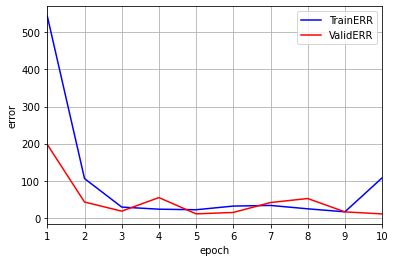

In [11]:
TrainERR=hist_x.history['loss']
ValidERR=hist_x.history['val_loss']
# print('@%f, Minimun error:%f, at iteration: %i' % (hist.history['val_loss'][epoch-1], np.min(np.asarray(ValidERR)),np.argmin(np.asarray(ValidERR))+1))
print('drawing the training process...')
plt.figure(2)
plt.plot(range(1,10+1),TrainERR,'b',label='TrainERR')
plt.plot(range(1,10+1),ValidERR,'r',label='ValidERR')
plt.xlim([1,epochs])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('error')
plt.grid(True)
fig1 = plt.gcf()
fig1.savefig('lstm20epochs_x.png', dpi=100)
plt.show()

In [14]:
#encoder model inference
encoder_model = Model(encoder_inputs, encoder_states)

#decoder model inference
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)


decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [15]:
def decode_sequence(input_seq):
    #input seq is a scene 
    # Encode the input as state vectors.
#     print("input seq shape is ",input_seq.shape)
    input_shaped = np.empty((1,19,1))
    input_shaped[0,:,:] = input_seq
#     encoder_model.summary()
#     input_shaped = np.reshape(input_seq, (input_seq.shape[0], 1, input_seq.shape[1]))
#     print("inpiut shaped is ", input_shaped)
    states_value = encoder_model.predict(input_shaped)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0,0,:] = input_seq[len(input_seq)-1] 

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    index = 0
    decoded_sentence = ''
    decoded_array = np.empty((30,1))
    while index < 30:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        
#         print("output tokens are ", output_tokens[0][0])
        
        # Sample a token
        decoded_array[index,:] = output_tokens[0][0]

        
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, :] = output_tokens
        # Update states
        states_value = [h, c]
    
        index += 1
    
    return decoded_array

In [16]:
columns = []
columns.append("ID")
for i in range(30):
    num = "v"+str(i+1)
    columns.append(num)
    
df = pd.DataFrame(columns=columns)

In [17]:
#testing portion
test_list = glob(os.path.join(test_path, '*'))
print(len(test_list))

for x in tqdm(test_list):
    test_x = np.empty((30,2))
    with open(x, 'rb') as f:
        data = pickle.load(f)
        new_row = []
        scene_id = data['scene_idx']
        new_row.append(scene_id)
        agent_id = data['agent_id']
        idx = np.where(data["track_id"] == data["agent_id"])[0][0]   
        input_data = data['p_in'][idx,:,0]
        input_data = input_data[..., np.newaxis]
        test_x = decode_sequence(input_data)
        flat = test_x.flatten()
        for elem in flat:
            new_row.append(elem)
        df_length = len(df)
        df.loc[df_length] = new_row

  0%|          | 0/3200 [00:00<?, ?it/s]

3200


100%|██████████| 3200/3200 [07:31<00:00,  7.08it/s]


In [18]:
df['ID'] = df['ID'].map(round)

In [19]:
df

,ID,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30
0,34189,601.159180,588.997314,594.746094,592.024658,590.381958,594.619385,594.648743,593.315979,592.496521,...,595.620911,595.621399,595.251038,594.664062,594.028076,593.467163,593.099121,593.041809,593.417542,594.352966
1,1454,587.140625,574.962952,579.964050,577.427185,575.089966,579.832031,579.972168,578.599731,577.859375,...,580.780212,580.763000,580.363220,579.749329,579.087952,578.500793,578.102722,578.008972,578.338806,579.215759
2,32404,596.732727,584.564148,590.072510,587.407959,585.538940,589.942200,590.007629,588.661438,587.867371,...,590.925232,590.919983,590.539978,589.944031,589.299622,588.730042,588.352112,588.283081,588.643982,589.560730
3,33991,416.081421,404.544800,404.680786,403.347717,380.736755,391.624451,392.082031,390.016235,384.688843,...,388.352417,388.132568,387.435120,386.572144,385.666687,384.804749,384.065918,383.528015,383.270447,383.376038
4,30427,598.003235,585.836365,591.413330,588.732361,586.927612,591.283936,591.339050,589.996643,589.195374,...,592.272034,592.268311,591.890991,591.297668,590.655579,590.088623,589.713440,589.647766,590.012817,590.934937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,7717,1901.393677,1892.818604,1916.614746,1895.533081,1900.964355,1901.874512,1901.999634,1902.828125,1903.159058,...,1907.666016,1907.196777,1906.136597,1904.374512,1902.487793,1900.852539,1899.842773,1899.834839,1901.219238,1904.401001
3196,5734,2046.086304,2037.857544,2063.426025,2040.508057,2046.234497,2047.511475,2047.787354,2048.757812,2049.229004,...,2053.990967,2053.492188,2052.352051,2050.455811,2048.426270,2046.668701,2045.585449,2045.582031,2047.077759,2050.510498
3197,33829,733.707275,721.858215,734.656433,728.702820,721.341248,731.009399,730.809143,729.217285,729.259827,...,731.756531,731.783936,731.486023,730.944580,730.344543,729.837341,729.563660,729.669434,730.303650,731.622498
3198,4515,586.793640,574.615784,579.598877,577.066772,574.713318,579.467041,579.609802,578.236450,577.498047,...,580.414124,580.396545,579.996155,579.381653,578.719788,578.131897,577.733093,577.638611,577.967102,578.842896


In [20]:
columns_test = []
columns_test.append("ID")
for i in range(38):
    num = "v"+str(i+1)
    columns_test.append(num)
    
df_test = pd.DataFrame(columns=columns_test)


for x in test_list:
    with open(x, 'rb') as f:
        data = pickle.load(f)
        new_row = []
        scene_id = data['scene_idx']
        new_row.append(scene_id)
        agent_id = data['agent_id']
        idx = np.where(data["track_id"] == data["agent_id"])[0][0]   
        input_data = data['p_in'][idx,:,:]
        for i in range(38):
            new_row.append(input_data.flatten()[i])
        df_length = len(df_test)
        df_test.loc[df_length] = new_row


In [21]:
df_test

,ID,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v29,v30,v31,v32,v33,v34,v35,v36,v37,v38
0,34189.0,595.562073,936.528992,595.544006,935.963928,595.649536,936.135559,595.667480,935.907166,595.707275,...,596.247437,933.134216,596.408813,932.617249,596.376892,932.458801,596.398865,932.383728,596.435852,932.086731
1,1454.0,579.748535,1236.775146,579.938965,1236.378784,580.365906,1235.755371,580.250061,1235.585815,580.636536,...,582.202637,1229.476196,582.441162,1228.873901,582.233643,1228.338623,582.358765,1227.714478,582.552185,1227.146851
2,32404.0,596.773865,1526.008545,596.632812,1526.094360,596.576294,1526.078125,596.498291,1526.105225,596.269348,...,593.871521,1525.996704,593.444214,1525.877930,592.983887,1525.745117,592.521118,1525.561646,592.052429,1525.351685
3,33991.0,416.036377,1131.377930,415.903534,1131.828003,415.764526,1132.141724,415.624969,1132.613525,415.485992,...,413.496155,1136.546021,413.229736,1136.827271,412.953491,1137.106201,412.656830,1137.415649,412.440948,1137.703003
4,30427.0,591.568970,986.132019,591.628113,985.414978,591.787476,984.686584,591.843811,984.013428,591.922363,...,592.989380,975.482605,592.937866,974.617676,593.038269,973.842896,593.211975,973.422119,593.310730,972.728210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,7717.0,1875.832397,471.821625,1876.988770,472.846069,1878.359009,473.901123,1879.551514,474.995544,1880.836060,...,1893.428467,486.367584,1894.691895,487.410950,1895.904175,488.400177,1897.126709,489.408905,1898.337891,490.422180
3196,5734.0,2069.424072,635.513184,2068.171631,634.562622,2066.786621,633.569031,2065.407471,632.559387,2064.130371,...,2050.308594,621.376709,2048.978516,620.367310,2047.582764,619.339417,2046.292236,618.321838,2044.849243,617.266418
3197,33829.0,726.628113,909.115906,726.607422,909.657166,726.652161,909.966309,726.634827,909.686401,726.640259,...,727.459900,912.470154,727.510315,912.951233,727.566162,913.033325,727.508850,913.745483,727.478943,914.257568
3198,4515.0,582.553650,1419.214355,582.546326,1418.776367,582.498047,1418.246216,582.581909,1417.869873,582.607849,...,582.132080,1412.069458,582.254089,1410.913574,582.018677,1410.472656,582.125854,1409.070923,582.208496,1408.635132


In [22]:
df.to_csv(r'./lstm_x.csv', index = False, header=True)